# Classification Part 2

In part 1 we implemented the kNN classifiet using the manually selected features for the classifier. In part 2 we try and implement an automated feature selection algorithm.

## I) Import the neccessary libraries and the dataframe

In [1]:
import numpy as np
import pandas as pd
# pd.set_option('mode.chained_assignment', 'raise')
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
# %matplotlib inline

import seaborn as sns

# Suppress warning about mixed data types in columns (change this later?)
import warnings
# warnings.filterwarnings('ignore')

# Import Some of the useful defined functions
import useful_fun as uf
# object with different useful regions defined
regions = uf.Regions()

In [2]:
# Extract the the zipped csv data if it already hasn't been extracted 
import os.path
import zipfile

if not os.path.isfile('./data/LiTS_III_2016.csv'):
    with zipfile.ZipFile("./data/LiTS_III_2016.zip","r") as zip_ref:
        zip_ref.extractall("./data/")
else:
    print('File already present')

File already present


In [3]:
# Reading the dataframe
lits_2016_full = pd.read_csv('./data/LiTS_III_2016.csv') # data in the repo folder linux
# lits_2016 = pd.read_csv('LiTS III.csv')

## II) Filter for all the categorical questions, adjust and prepare them for use in classification.
* Clean and filter the dataframe for only categorical question
* Turn the categorical question into hot shot questions.

In [4]:
# Find all the columns that are question columns
all_question_col = list(uf.findColumn('q',lits_2016_full));
np.shape(all_question_col)

(565,)

In [5]:
# create a Dataframe with only the question columns and necessary columns
lits_2016_questions_only = lits_2016_full[all_question_col];

In [6]:
# Check for null values
checkNull = lits_2016_questions_only.isnull().sum().sort_values(ascending=False)

#### We are trying to only use columns that have greatest coverage in the dataset, so we drop columns that have high null value proportion.

In [9]:
# Drop the columns that have more than 1000 null values
columns_with_few_nulls = list(checkNull[checkNull<1000].index)
np.shape(columns_with_few_nulls)


(234,)

#### There are question columns that don't have letter 'q' at the begining of the column name, also we need to make sure to retain columns that we either plan or are using as the class columns.

In [10]:
# What are definitely neccessary columns?
needed_col =[
    'country',#     'Country',
    'q412',#        'Political System',
    'q411',#        'Economy Type',
]

# Append the necesssary columns to the columns
for col in needed_col:
    try:
        columns_with_few_nulls.index(col)
    except:
        columns_with_few_nulls.append(col)

np.shape(columns_with_few_nulls)

(235,)

In [11]:
# Select the columns that are left over and drop the values that are nan
lits_2016_selected = lits_2016_full[columns_with_few_nulls];
lits_2016_selected = lits_2016_selected.dropna()
lits_2016_selected.shape


(47684, 235)

In [12]:
# remove columns with only 1 unique value, these questions, don't add information
rem_cols = [];
for column in lits_2016_selected:
    nr_values= len(np.unique(lits_2016_selected[column]))
    if nr_values == 1:
        print('{} col has No {} of values'.format(column, nr_values))
        rem_cols.append(column)

lits_2016_selected = lits_2016_selected.drop(rem_cols,axis=1)
lits_2016_selected.shape

q413_97 col has No 1 of values
q413_96 col has No 1 of values
q102_1 col has No 1 of values
q217b col has No 1 of values


(47684, 231)

In [13]:
# remove greece questions left over, as we know for a fact that they are only refferential to a very small group in the dataset
rem_cols = [
    'q1008_other',
    'q1009_other',
    'q1010_other',
    'q1012_other'
]

lits_2016_selected = lits_2016_selected.drop(rem_cols,axis=1)
lits_2016_selected.shape

(47684, 227)

In [14]:
# Others that we don't think can be turned into features in our approach
rem_cols = [
    'q105_1',              # - age
    'q927',                # - height
    'q906b',               # - place
    'q911b',               # - place
    'q914b',               # - place
    'q923_ethnicity',      # - too many       
    'q902',                # - weight
    'q909b',               # - placed moved from
    'q910b',               # - place of origin
    'q907b',               # - place
]

lits_2016_selected = lits_2016_selected.drop(rem_cols,axis=1)
lits_2016_selected.shape

(47684, 217)

#### Remove the feture columns that are clearly numerical or with very large number of categories.

In [16]:
# Leave only categorical features with less than 14 categories 

features = []
potential_bin_features = 0
for column in lits_2016_selected:
    nr_values= len(np.unique(lits_2016_selected[column]))
    if nr_values <= 14:
        potential_bin_features = potential_bin_features+nr_values;
        features.append(column)

lits_2016_selected = lits_2016_selected[features]
# Also set all the datatypes as ints
lits_2016_selected = lits_2016_selected.astype(int)
lits_2016_selected.shape

(47684, 203)

In [17]:
# Create a dataframe with binary features from the existing categorical features.

lits_2016_selected_dummies = pd.get_dummies(lits_2016_selected, columns = features,prefix_sep='_')

# Keep the classification column
class_col= 'Political System'
lits_2016_selected_dummies[class_col] = lits_2016_selected['q412']

# Remove the political system binary features
rem_cols = list(uf.findColumn('q412',lits_2016_selected_dummies))
lits_2016_selected_dummies = lits_2016_selected_dummies.drop(rem_cols,axis=1)


lits_2016_selected_dummies.shape

(47684, 1068)

In [18]:
# Check that the last column is Political System.
list(lits_2016_selected_dummies.columns)[-1:]

['Political System']

In [19]:
# Set different catergorical classes to strings to make it clearer
replace = {'Political System':{
 1: 'democratic',
 2: 'authoritarian',
 3: 'indifferent',
 -97 : 'dont know'},
 }
lits_2016_selected_dummies = lits_2016_selected_dummies.replace(replace);
np.unique(lits_2016_selected_dummies[class_col])

array(['authoritarian', 'democratic', 'dont know', 'indifferent'],
      dtype=object)

## III) Feature selection
* Create a dataframe with classes as columns, with each class counts per question
* Create two versions of this datafram. One normalized column wise, other row wise.
* Create the final dataframe, by multiplying the two normalized dataframes.
* Sort the the final dataframe, per column and put the top highest weighted value question column names in the selected feature set.

In [20]:
# Find the unique lables in the class column
col_count = np.unique(lits_2016_selected_dummies[class_col])

# Create a DF with classes as columns and questions as rows
df_counts = pd.DataFrame(index=lits_2016_selected_dummies.iloc[:,:-1].columns,columns=col_count)
df_counts.shape

(1067, 4)

In [25]:
# Create a copy where you'll store the normalized count values
df_counts_normalized = df_counts.copy()

# Creates two dataframes, one with just counted values and with values normalized row wise
for index in df_counts.index:
    ser = lits_2016_selected_dummies.value_counts([index,'Political System'])
    ser_normalized = lits_2016_selected_dummies.value_counts([index,'Political System'],normalize=True)
    for col in df_counts.columns:
        try:
            df_counts.loc[index,col] = ser[1][col]
            df_counts_normalized.loc[index,col] = ser_normalized[1][col]
        except:
            df_counts.loc[index,col] = 0
            df_counts_normalized.loc[index,col] = 0

In [26]:
 df_counts_normalized.head()

,authoritarian,democratic,dont know,indifferent
q218b_-97,0.000105,0.000377,0.000273,0.000147
q218b_1,0.003418,0.010108,0.001887,0.004865
q218b_2,0.009269,0.028123,0.005264,0.011346
q218b_3,0.017343,0.047332,0.009731,0.021139
q218b_4,0.11421,0.328056,0.055742,0.143193


In [29]:
#  Creates a dataframe with values normalized column wise
df_counts_normalized_columns = df_counts.apply(lambda x: x/x.max(), axis=0)
df_counts_normalized_columns.head()

,authoritarian,democratic,dont know,indifferent
q218b_-97,0.000582,0.000736,0.003234,0.00066
q218b_1,0.018978,0.019706,0.022388,0.02186
q218b_2,0.051461,0.054824,0.062438,0.050975
q218b_3,0.096286,0.092273,0.115423,0.094978
q218b_4,0.634067,0.639534,0.661194,0.643362


In [30]:
# Create the weighted valaue dataframe for the feature selection
df_final = df_counts_normalized_columns * df_counts_normalized
df_final.head()

,authoritarian,democratic,dont know,indifferent
q218b_-97,0.0,0.0,0.000001,0.0
q218b_1,0.000065,0.000199,0.000042,0.000106
q218b_2,0.000477,0.001542,0.000329,0.000578
q218b_3,0.00167,0.004368,0.001123,0.002008
q218b_4,0.072417,0.209803,0.036856,0.092125


### Create a feature set to be used in the classifier.

In [53]:
# Create an empty set to add the feature columns to
feature_set = set()
# Number of top features to add
top_from_column = 50
for col in df_final.columns:
    # print the top 5 in each column for information
    print(df_final.loc[:,col].sort_values(ascending = False).head(5).index)
    feature_set.update(df_final.loc[:,col].sort_values(ascending = False).head(top_from_column).index)
final_features = list(feature_set)
final_features.append(class_col)
print('{} features selected from {} top in each class'.format(len(final_features),top_from_column))

Index(['q104_1_1', 'q408_97_0', 'q408g_0', 'q413_95_0', 'q202b_1'], dtype='object')
Index(['q104_1_1', 'q408_97_0', 'q408g_0', 'q413_95_0', 'q202b_1'], dtype='object')
Index(['q104_1_1', 'q408g_0', 'q408_97_0', 'q919e_3', 'q919h_3'], dtype='object')
Index(['q104_1_1', 'q408_97_0', 'q408g_0', 'q429_99_0', 'q202b_1'], dtype='object')
56 features selected from 50 top in each class


## IV) Use the selected features for classification
* First without balancing and then with

Training set:	 33379 examples
Valid set:	 4768 examples
Test set:	 9537 examples


democratic       0.513946
indifferent      0.222745
authoritarian    0.180083
dont know        0.083226
Name: Political System, dtype: float64

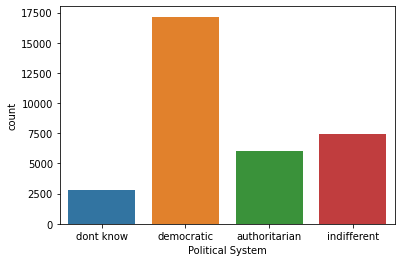

In [61]:
# Create a dataframe with the selected feature columns
selected_df = lits_2016_selected_dummies[final_features].copy()

# Number of nearest neighbours used
nearest_neighb = 7

# Split the dataset
train, test, valid = uf.train_test_valid(selected_df)

# Plot the ditribution of clases in the training part of the dataset
sns.countplot(train[class_col]);
train[class_col].value_counts(normalize=True)

### Perform the classification on a non balanced dataset
NB! This takes a while to execute

In [55]:
# Copy original split into new dataframes to not mix up guess outputs
train_not_balanced = train.copy()
test_not_balanced = test.copy()


#  Run the classifier on all the test values from the balanced training dataset
test_not_balanced['Guesses'] = test_not_balanced.apply(uf.predict_nn,args=(train_not_balanced, nearest_neighb, class_col), axis = 1)

# Check for accuracy
uf.calculate_accuracy(test_not_balanced,class_col)

authoritarian - 28.05%:
democratic - 60.26%:
dont know - 62.05%:
indifferent - 60.20%:

Total Accuracy - 57.26%:


### Reasonalbe results, let's try and balance the training set and see what result that gives

authoritarian    2817
democratic       2817
dont know        2817
indifferent      2817
Name: Political System, dtype: int64

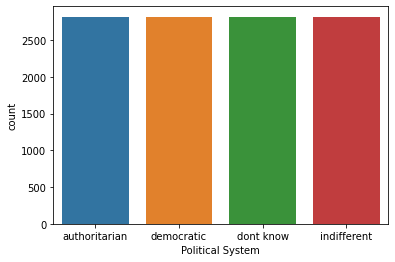

In [56]:
# Copy original split into new dataframes to not mix up guess outputs
train_balanced_not_boot = train.copy()
test_balanced_not_boot = test.copy()

# Balance the training dataset, by equaling the dataset size to the smallest size of the claseses.
train_balanced_not_boot = uf.balance_df(train_balanced_not_boot,class_col)

# Plot the ditribution of clases in the balanced training part of the dataset
sns.countplot(train_balanced_not_boot[class_col]);
train_balanced_not_boot[class_col].value_counts()

In [57]:
#  Run the classifier on all the test values from the balanced training dataset
test_balanced_not_boot['Guesses'] = test_balanced_not_boot.apply(uf.predict_nn,args=(train_balanced_not_boot, nearest_neighb, class_col), axis = 1)

# Check for accuracy
uf.calculate_accuracy(test_balanced_not_boot,class_col)

authoritarian - 25.52%:
democratic - 66.36%:
dont know - 41.78%:
indifferent - 55.17%:

Total Accuracy - 47.85%:


## V) Conclusions part 2
Performing a different way of selecting features in a more automatic manner performed at a similar level as did manual feature selection. The main difference was a more even performance accross different classes, comparing to manual selection method.

the attempts at balancing the datasets did not improve results.

There are many more methods how the selection process could be extended and further tested:
* Varrying the number of nearest neighbour count and observing the accuracy change. 
* Performing a random feature selection, to see if performance differs from top weighed feature selection.
* Varrying the number of features to see how much that would affect the performance.

Another point of interest is the nature of the top questions that were automatically chosen.

* q104 - household head 
* q408 - who deserves support?
* q413 - most addressing problems that the government should address.
* q202b - household possessions
* q919 - membership in voluntary organizations 
* q429 - different types of minorities as neighbours (for / against)

None of these questions were chosen in the manual selection, yet after having them being selected automatically. When looking up the questions, you can see that the underlying answers could potentially be politically charged.

#### We test the most successful classifier implementation without balancing on the validation dataset.

In [62]:
#  Run the classifier on all the validation values using the not balanced dataset
valid['Guesses'] = valid.apply(uf.predict_nn,args=(train_not_balanced, nearest_neighb, class_col), axis = 1)
# Check for accuracy
uf.calculate_accuracy(valid,class_col)

authoritarian - 47.06%:
democratic - 64.52%:
dont know - 72.38%:
indifferent - 67.56%:

Total Accuracy - 63.63%:
